In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

np.set_printoptions(precision=3, suppress=True)
#tf.random.set_seed(1)

def get_feat_and_labels(filename, as_tensor = True):
    data = pd.read_csv(filename)

    data["Angle"] = np.abs(np.arctan2(data["OppY"], data["OppX"]))
    data["OppY"] = np.abs(data["OppY"])
    data = data[["Angle",  "DistanceToGoal", "DistanceToOpp",  "OppX", "OppY","Success"]]
    
    #Converting text yes no to int.
    if(data["Success"].dtype == object):
        data["Success"] = (data["Success"] == "YES")*1
    
    if(as_tensor):
        return tf.convert_to_tensor(data.drop(columns="Success"),dtype=tf.float32), \
                tf.convert_to_tensor(data["Success"],dtype=tf.float32),\
                data.copy() 
    else:
        return data.drop(columns="Success"), data["Success"], data.copy() 


In [2]:
"""Code used to create training data"""
    
from sklearn.model_selection import train_test_split

def printCount(data):
    if type(data) == pd.DataFrame:
        success_no = data[data['Success'] == 0]
        success_yes = data[data['Success'] == 1]
    else:
        success_no = data[data == 0]
        success_yes = data[data == 1]
    print('success no:', success_no.shape[0])
    print('success yes:', success_yes.shape[0])
    
def get_data(names):
    _, _, original_data = get_feat_and_labels(names[0], as_tensor=False)
    
    print(names[0])#,original_data)
    printCount(original_data)
    for n in names[1:]:
        _, _, d = get_feat_and_labels(n, as_tensor=False)        
        print(n)#,_)
        printCount(d)
        original_data = pd.concat([original_data, d],axis=0)
    
    printCount(original_data)
    return original_data

# data_names = [
#                 "..\MotionTestingData\CanShootTolLocal2x.csv",
#                 "..\MotionTestingData\CanShootTolLocal3x.csv",
#                 "..\MotionTestingData\CanShootTolLocal4x.csv",
#                 "..\\NewGoodData\Testfeb8num3\CanShoot2MotionTol2x.csv",
#                 "..\\NewGoodData\Testfeb8num3\CanShoot2MotionTol3x.csv",
#                 "..\\NewGoodData\Testfeb8num3\CanShoot2MotionTol4x.csv",
#                 "..\\NewGoodData\Testfeb8num3\CanShoot2plus75tolerance.csv",
#                 "..\\NewGoodData\Testfeb8num3\CanShoot2Tol3x.csv",
#                 "..\\NewGoodData\Testfeb8num3\CanShoot2Tol4x.csv",

#                 "..\\NewGoodData\Testfeb8num3\CanShoot2Tolerance2x.csv",
#                 "..\\NewGoodData\Originals\CanShoot2Behavior.csv",
#                 "..\\NewGoodData\Originals\CanShoot2Bottom.csv",
#                 "..\\NewGoodData\Originals\CanShoot2Upper.csv",
#                 "..\\NewGoodData\Originals\CanShoot2Mid.csv",
    
#                  #"..\\NewGoodData\Originals\CanShoot2Center.csv",
#                  #"..\MotionTestingData\CanShootStillLocal3x.csv",
#              ]

data_names = [
               "..\MotionTestingData\CanShootStillLocal3x.csv",#still
                
                "..\MotionTestingData\CanShootTolLocal2x.csv",#Motion
                "..\MotionTestingData\CanShootTolLocal3x.csv",#Motion
                "..\MotionTestingData\CanShootTolLocal4x.csv",#Motion
                
                "..\\NewGoodData\Testfeb8num3\CanShoot2MotionTol2x.csv",#Motion
                "..\\NewGoodData\Testfeb8num3\CanShoot2MotionTol3x.csv",#Motion
                "..\\NewGoodData\Testfeb8num3\CanShoot2MotionTol4x.csv",#Motion
                
                "..\\NewGoodData\Testfeb8num3\CanShoot2plus75tolerance.csv",#still
                "..\\NewGoodData\Testfeb8num3\CanShoot2Tol3x.csv",#still
                "..\\NewGoodData\Testfeb8num3\CanShoot2Tol4x.csv",#still
                "..\\NewGoodData\Testfeb8num3\CanShoot2Tolerance2x.csv",#still
                
                "..\\NewGoodData\Originals\CanShoot2Behavior.csv",#motion
                
                "..\\NewGoodData\Originals\CanShoot2Bottom.csv",#still
                "..\\NewGoodData\Originals\CanShoot2Upper.csv",#still
                "..\\NewGoodData\Originals\CanShoot2Center.csv",#still
                "..\\NewGoodData\Originals\CanShoot2Mid.csv"#still

             ]

simple_load = True

if(simple_load):  
    can_shoot_features, can_shoot_labels, _ = get_feat_and_labels("TrainFinal.csv" )
    cs_feat_valid, cs_labels_valid, _ = get_feat_and_labels("ValidFinal.csv" )
    
else: #This is how the stratified train/valid split was created.
    data_og = get_data(data_names)

    can_shoot_features, cs_feat_valid, can_shoot_labels, cs_labels_valid = train_test_split(data_og.drop(columns="Success"), data_og["Success"], test_size=0.33, random_state=3, stratify=data_og["Success"])

    printCount(can_shoot_labels)
    printCount(cs_labels_valid)

    can_shoot_features = tf.convert_to_tensor(can_shoot_features, dtype=tf.float32) 
    can_shoot_labels = tf.convert_to_tensor(can_shoot_labels, dtype=tf.float32)  

    cs_feat_valid = tf.convert_to_tensor(cs_feat_valid, dtype=tf.float32) 
    cs_labels_valid = tf.convert_to_tensor(cs_labels_valid, dtype=tf.float32) 

In [3]:
"""Write dataframe back to csv after processing data"""
def writeToCSV(features, labels, name):
    to_csv_var = pd.DataFrame(tf.concat([features, tf.expand_dims(labels, axis=1)], axis=1).numpy(),
                                       columns=["Angle",  "DistanceToGoal", "DistanceToOpp",  "OppX", "OppY","Success"])
    to_csv_var["Success"] = to_csv_var["Success"]==1
    to_csv_var.to_csv(name, index=False)
    
# writeToCSV(can_shoot_features, can_shoot_labels, "TrainFinal.csv" )
# writeToCSV(cs_feat_valid, cs_labels_valid, "ValidFinal.csv" )

# Train Model loop

In [4]:
tf.keras.backend.clear_session()

num_feats = can_shoot_features.shape[1]

model = tf.keras.models.Sequential([
  tf.keras.layers.BatchNormalization(input_dim=num_feats),
  tf.keras.layers.Dense(6, activation='relu'),
 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(3, activation='swish'),

  tf.keras.layers.Dense(1, activation='sigmoid') 
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.05),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()], 
)

model.summary()

from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=75, min_lr=0.001)


model.fit(
    can_shoot_features,
    can_shoot_labels,
    batch_size=16,
    epochs = 64,   
    validation_data= (cs_feat_valid, cs_labels_valid ),
    callbacks=[reduce_lr] 
)


#add early stopping
early_stop= tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=50, verbose=0,
    mode='min', baseline=None, restore_best_weights=True
)

model.fit(
    can_shoot_features,
    can_shoot_labels,
    batch_size=16,
    epochs = 512,   
    validation_data= (cs_feat_valid, cs_labels_valid ),
    callbacks=[reduce_lr, early_stop] 
)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 5)                20        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 6)                 36        
                                                                 
 batch_normalization_1 (Batc  (None, 6)                24        
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 3)                 21        
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 105
Trainable params: 83
Non-trainable par

KeyboardInterrupt: 

# Summary of Trained Model

In [4]:
def getAcc_Rec_Prec(conf_mat):
    accuracy = (conf_mat[0,0]+conf_mat[1,1])/np.sum(conf_mat)

    recall = conf_mat[1,1]/sum(conf_mat[1,:])

    precision = conf_mat[1,1]/sum(conf_mat[:,1])
    
    return accuracy, recall, precision

def getPosNeg(prediction, actual):
    tp,fp,tn,fn = 0,0,0,0
    for i in range(len(prediction)):
        if(np.round(prediction[i]) == 1):
            if(np.round(prediction[i]) == actual[i]):
                tp+=1
            else:
                fp+=1
        else:
            if(np.round(prediction[i]) == actual[i]):
                tn+=1
            else:
                fn+=1
    return tp,fp,tn,fn
            

In [5]:
results = model.evaluate(can_shoot_features, can_shoot_labels)
print("Final train_ loss, train_acc:", results)

results = model.evaluate(cs_feat_valid, cs_labels_valid)
print("Final val_ loss, val_acc:", results)

out=model.predict(cs_feat_valid)
# out = tf.squeeze(out)

conf_mat = tf.math.confusion_matrix(cs_labels_valid, np.round(out))
print(conf_mat)

NameError: name 'model' is not defined

# Logistic Regression Results

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

#lr_model = LogisticRegression(solver='liblinear', random_state=0)
lr_model = LogisticRegression(solver='liblinear')

#Build logistic regressor on Training Set
lr_model.fit(can_shoot_features, can_shoot_labels)



#Output results on Validation set
output_lr = lr_model.predict(cs_feat_valid)

lr_conf_mat = confusion_matrix(cs_labels_valid, output_lr)

lr_acc, lr_rec, lr_prec = getAcc_Rec_Prec(lr_conf_mat)

print("LogisticRegression_Accuracy: ",lr_acc)
print("LogisticRegression_Recall: ", lr_rec)
print("LogisticRegression_Precision: ", lr_prec)

LogisticRegression_Accuracy:  0.8715083798882681
LogisticRegression_Recall:  0.7592592592592593
LogisticRegression_Precision:  0.803921568627451


# Save model if wanted. Specify folder directory

In [47]:
save = False
if(save):
    write_name='Feb13StratifiedModel'
    model.save(write_name, save_format='tf')
    import subprocess
    #Prints out information needed on C++ side
    subprocess.check_output("saved_model_cli show --dir "+write_name+" --tag_set serve --signature_def serving_default")


# Test Results

In [5]:
load_trained_model = True
if(load_trained_model):
    model = tf.keras.models.load_model('Feb13StratifiedModel/')
    
    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 5)                20        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 6)                 36        
                                                                 
 batch_normalization_1 (Batc  (None, 6)                24        
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 3)                 21        
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 105
Trainable params: 83
Non-trainable par

In [15]:
test_names = ["TestResults\CanShoot2MotionTol2x.csv",
              "TestResults\CanShoot2MotionTol3x.csv",
              "TestResults\CanShoot2MotionTol4x.csv",
              "TestResults\CanShootStillTol2x.csv"
             ]
test_feat, test_label, _ = get_feat_and_labels(test_names[0], as_tensor=False)
data_test = test_feat
data_label = test_label
for n in test_names[1:]:
    f,l,_ = get_feat_and_labels(n, as_tensor=False)
    test_feat = pd.concat([test_feat, f], axis = 0)
    test_label = pd.concat([test_label, l], axis = 0)
    

test_feat = tf.convert_to_tensor(test_feat, dtype=tf.float32)
test_label = tf.convert_to_tensor(test_label, dtype=tf.float32)



results = model.evaluate(test_feat, test_label)

print("Final train_ loss, train_acc:", results)

test_out = model.predict(test_feat)

test_conf = tf.math.confusion_matrix(test_label, np.round(test_out))

print(test_conf)






NameError: name 'model' is not defined

# Logistic Regression models performance on the Test Data

In [12]:

print("\n_____________________________\n|Logistic Regression Results|")
output_lr = lr_model.predict(test_feat)

lr_conf_mat = confusion_matrix(test_label, output_lr)
print(lr_conf_mat)

lr_acc, lr_rec, lr_prec = getAcc_Rec_Prec(lr_conf_mat)

print("LogisticRegression_Accuracy: ",lr_acc)
print("LogisticRegression_Recall: ", lr_rec)
print("LogisticRegression_Precision: ", lr_prec)


_____________________________
|Logistic Regression Results|


NameError: name 'lr_model' is not defined

In [30]:
np.set_printoptions(precision=100, suppress=True)

fun = lr_model.coef_[0]
print(fun)
print(lr_model.intercept_)
intr = lr_model.intercept_ 
# out = fun * test_feat
# pred = out.numpy().sum(axis=1) 
# pred[:] = pred[:]>=0

import time
start_time = time.time()
t_feat = test_feat.numpy()
for i in range(0,94):
    pred = 0*0.0018335686493680826 +0*-0.001815020190297834 +1*0.005378647991601562 +6*-0.00862947931490611  +7*0.03296512379693194 + 0.011938457842768207
print("--- %s seconds ---" % ((time.time() - start_time)/(94.0)) )

# print(data_test.head())

[ 0.0018335686493680826 -0.001815020190297834   0.005378647991601562
 -0.00862947931490611    0.03296512379693194  ]
[0.011938457842768207]
--- 1.064767228796127e-05 seconds ---


[[ 2.119 -0.002]]
[3.884]
[4.413]
-0.1881


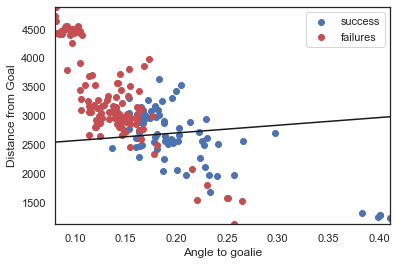

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns

#lr_model = LogisticRegression(solver='liblinear', random_state=0)
lr_model = LogisticRegression(solver='liblinear')

#Build logistic regressor on Training Set
example_feat = can_shoot_features[:, :2]
lr_model.fit(example_feat, can_shoot_labels)


example_test = test_feat[:, :2]
#Output results on Validation set
output_lr = lr_model.predict(example_test)

success_plot = example_test[test_label == True]
fail_plot = example_test[test_label == False]

w = lr_model.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx - (lr_model.intercept_[0]) / w[1]

plt.scatter(success_plot[:,0], success_plot[:,1], c='b', label='success')
plt.scatter(fail_plot[:,0], fail_plot[:,1], c='r', label='failures')

#ax.legend(label='success')
#ax.legend(label='failures')


plt.axis([example_test[:,0].numpy().min(),example_test[:,0].numpy().max() \
          ,example_test[:,1].numpy().min(),example_test[:,1].numpy().max()])

plt.legend()
plt.plot(xx, yy, 'k-')
plt.ylabel("Distance from Goal")
plt.xlabel("Angle to goalie")

print(lr_model.coef_)
print(lr_model.intercept_)

coordinate = np.array([.4,200])
                      
print( (coordinate*lr_model.coef_).sum() +lr_model.intercept_)
print((.1*2.119 + 200*-.002))


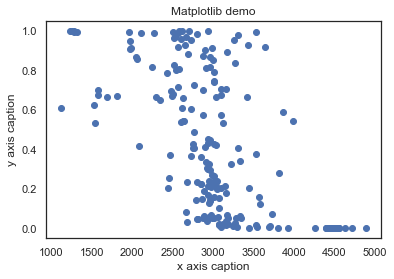

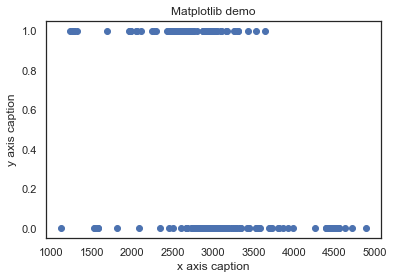

In [22]:
from matplotlib import pyplot as plt 

#x = np.arange(1,11) 
#y = 2 * x + 5 
plt.title("Matplotlib demo") 
plt.xlabel("x axis caption") 
plt.ylabel("y axis caption") 

feat_to_plot = test_feat[:,1]
plt.scatter(feat_to_plot,lr_model.predict_proba(test_feat)[:,1])
#plt.plot(test_feat,fun) 
plt.show()

plt.title("Matplotlib demo") 
plt.xlabel("x axis caption") 
plt.ylabel("y axis caption") 

plt.scatter(feat_to_plot, test_label)
plt.show()




In [7]:
f, ax = plt.subplots(figsize=(7, 7))
c1, c2 = "#3366AA", "#AA3333"
ax.scatter(*x1_samples.T, c=c1, s=40)
ax.scatter(*x2_samples.T, c=c2, marker="D", s=40)
x_vec = np.linspace(*ax.get_xlim())
ax.contour(x_vec, x_vec,
           decision_boundary(x_vec, mu_vec1, mu_vec2),
           levels=[0], cmap="Greys_r")

NameError: name 'plt' is not defined

(30, 500000)
(30, 500000)


[None, (0.0, 0.3), (0.0, 5000.0), Text(0.5, 0, '$X_1$'), Text(0, 0.5, '$X_2$')]

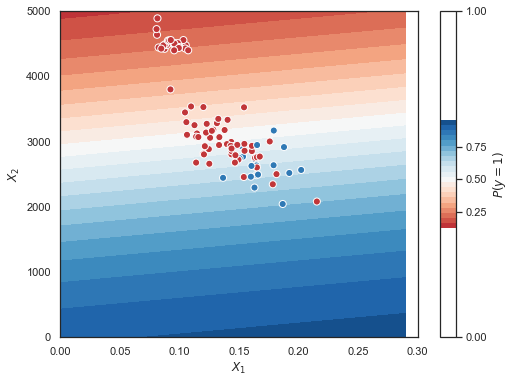

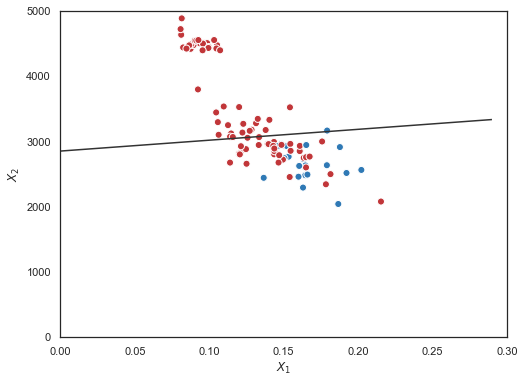

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
# First, generate the data and fit the classifier to the training set:
X = test_feat[: , 0:2]
# print(X[:,0:1].shape)
# X = tf.concat([X[:, 1:], X[:,0:1]], axis=1)

y = test_label
clf = LogisticRegression().fit(X[:100], y[:100])
# Next, make a continuous grid of values and evaluate the probability of each (x, y) point in the grid:
# xmin, xmax = X[100:,0].numpy().min(), X[100:,0].numpy().max()
# ymin, ymax = X[100:,1].numpy().min(), X[100:,1].numpy().max()

xmin, xmax = 0, .3
ymin, ymax = 0, 5000

#xx, yy = np.mgrid[-5:5:.01, -0:5000:.01]
xx, yy = np.mgrid[xmin:xmax:.01, ymin:ymax:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
print(xx.shape)
print(yy.shape)
probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)
# Now, plot the probability grid as a contour map and additionally show the test set samples on top of it:

f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

# ax.set(aspect="equal",
#        xlim=(-5, 5), ylim=(-5, 5),
#        xlabel="$X_1$", ylabel="$X_2$")
ax.set(aspect="auto", 
       xlim=(xmin, xmax), ylim=(ymin, ymax),
       xlabel="$X_1$", ylabel="$X_2$")
# enter image description here

# The logistic regression lets your classify new samples based on any threshold you want, so it doesn't inherently have one "decision boundary." But, of course, a common decision rule to use is p = .5. We can also just draw that contour level using the above code:

f, ax = plt.subplots(figsize=(8, 6))
ax.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6)

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="auto",
       xlim=(xmin, xmax), ylim=(ymin, ymax),
       xlabel="$X_1$", ylabel="$X_2$")